# differential-expression-analysis-lupine-v1
6.28.24

todo: add description

In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from Bio import SeqIO
from scipy import stats
from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette("tab10")

#### Configs

In [22]:
# The unimputed joint quants matrix
joint_fname="/net/noble/vol2/home/lincolnh/data/quant-data/UMich-normalized/joint-quants-normalized-shifted.csv"
min_pres=18

# The Lupine recon matrix
lupine_recon_ensembled_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-30_DE_sandbox/results/lupine-ensemble-imputed.csv"

# The Ensemble (GENCODEv44) fasta
ensembl_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2023-11-13_UMich_dataset/fastas/"
ensembl_df="gencode.v44.pc_translations.fa"

# The HGNC database file
hgnc_database_path="/net/noble/vol2/home/lincolnh/data/quant-data/HGNC_database.txt"

# The metadata dictionary, previously created
meta_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-10_metadata_mapping/meta-dict.csv"

cohort_ids=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
            "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

# Set the thresholds
adjusted_alpha=1e-2
fc_thresh=0.5
pres_frac_thresh=0.5 # Default here is 50%

curr_cohort = "CCRCC"

rng = np.random.default_rng(seed=18)

#### Functions

In [23]:
def bh_adjustment(pvals):
    """
    Performs the Benjamini-Hochberg procedure
    for p-value ADJUSTMENT. So this means we actually 
    return a list of corrected p-values, not just a 
    boolean specifying which p-values to keep per the
    FDR controlled at some threshold. 
    
    Parameters
    ----------
    pvals : np.ndarray, 
        The sorted list of uncorrected p-values. Sorted
        from smallest to largest

    Returns
    -----------
    pvals_adjusted : list, 
        A list of the BH adjusted p-values
    """
    pvals_adjusted = []

    for i in range(0, len(pvals)):
        rank = i + 1
        curr_pval = pvals[i]
        pval_adj = (curr_pval * len(pvals)) / rank
        pvals_adjusted.append(pval_adj)        

    return pvals_adjusted

#### Subset the metadata to a single cohort, get the tumor and nontumor sample IDs

In [24]:
# Might need `index_col=0` here
meta_dict = pd.read_csv(meta_path)
meta_dict = meta_dict[meta_dict["cohort"] == curr_cohort]
meta_dict = meta_dict.reset_index(drop=True)

tumor_samples_meta = meta_dict[(meta_dict["sample_type"] == "Primary Tumor") | (meta_dict["sample_type"] == "Tumor")]
nontumor_samples_meta = meta_dict[(meta_dict["sample_type"] != "Primary Tumor") & (meta_dict["sample_type"] != "Tumor")]

tumor_IDs = list(tumor_samples_meta["aliquot_ID"])
nontumor_IDs = list(nontumor_samples_meta["aliquot_ID"])

print(len(tumor_IDs))
print(len(nontumor_IDs))

110
84


#### Pre-process the unimputed joint quants matrix
This should get us to the exact same starting point as the Lupine ensemble impute procedure. 

In [25]:
# Read in the joint quants matrix
joint_mat = pd.read_csv(joint_fname, index_col=0)

# Remove some of these extraneous runs
keywords = ["RefInt", "QC", "pool", "Tumor", "Pooled", 
            "Pool", "Reference", "NCI", "NX", "Ref"]
to_drop = []

for sample_id in list(joint_mat.columns):
    exclude=False
    for kw in keywords:
        if kw in sample_id:
            exclude=True
            break
    to_drop.append(exclude)

keep_cols = np.array(joint_mat.columns)[~np.array(to_drop)]
joint_mat = joint_mat[keep_cols]

joint = np.array(joint_mat)

# Remove proteins with too many missing values
num_present = np.sum(~np.isnan(joint), axis=1)
discard = num_present < min_pres
joint = np.delete(joint, discard, axis=0)
keep_prots = np.array(joint_mat.index)[~discard]

print(f"joint quants mat shape, post-filter: {joint.shape}")

joint_start = pd.DataFrame(joint, columns=keep_cols, index=keep_prots)

joint quants mat shape, post-filter: (18162, 1755)


#### Remove the proteins with >50% missingness
From the unimputed runs corresponding to the current cohort. 

In [26]:
cohort_quants_start = joint_start[tumor_IDs + nontumor_IDs]

num_present = np.sum(~np.isnan(cohort_quants_start), axis=1)
pres_fracs = num_present / cohort_quants_start.shape[1]

cohort_quants_start = cohort_quants_start[pres_fracs >= pres_frac_thresh]
print(cohort_quants_start.shape)

keep_prots_cohort = list(cohort_quants_start.index)

(9324, 194)


#### Read in the Lupine imputed quants and subset by initial missingness fraction

In [27]:
lupine_recon = pd.read_csv(lupine_recon_ensembled_path, index_col=0)
lupine_recon = lupine_recon.loc[keep_prots_cohort]
print(lupine_recon.shape)

(9324, 1755)


#### Exponentiate to get the original, untransformed intensities
These quants had previously been log2 transformed (by the CPTAC project). So we're inversing that transformation. 

In [28]:
joint_start = np.power(2, joint_start)
lupine_recon = np.power(2, lupine_recon)

#### Get quants matrices for tumor and non-tumor samples

In [29]:
tumor_quants = lupine_recon[tumor_IDs]
nontumor_quants = lupine_recon[nontumor_IDs]

tumor_mat = np.array(tumor_quants)
nontumor_mat = np.array(nontumor_quants)

#### Calculate the Wilcoxon-rank sum statistics

In [30]:
pvals = []
rs_stats = []

for i in range(0, tumor_mat.shape[0]):
    stat, pval = stats.ranksums(tumor_mat[i], nontumor_mat[i], nan_policy="omit")
    pvals.append(pval)
    rs_stats.append(stat)

# Init a dataframe to hold the p-values and adjusted p-values
stats_df = pd.DataFrame(columns = ["ENSP", "pval", "adj_pval", "orig_idx"])
stats_df["ENSP"] = list(tumor_quants.index)
stats_df["pval"] = pvals

#### Do the Benjamini-Hochberg correction

In [31]:
# Sort by uncorrected p-values
stats_df = stats_df.sort_values(by="pval")
# Do the BH adjustment
pvals_corrected = bh_adjustment(np.array(stats_df["pval"]))
stats_df["adj_pval"] = pvals_corrected
stats_df["orig_idx"] = list(stats_df.index)

# Return to the initial order
stats_df = stats_df.sort_values(by="orig_idx")

#### Get the log fold changes

In [32]:
tumor_expr_means = np.nanmean(tumor_mat, axis=1)
nontumor_expr_means = np.nanmean(nontumor_mat, axis=1)

log_fold_changes = np.log2(tumor_expr_means / nontumor_expr_means)

fdr = -np.log10(np.array(stats_df["adj_pval"]))

#### Create an aggregated dataframe for analysis

In [33]:
aggregated = pd.DataFrame(columns=["ENSP", "HGNC", "p-value", "FC"])
aggregated["ENSP"] = list(tumor_quants.index)
aggregated["p-value"] = np.array(stats_df["adj_pval"])
aggregated["FC"] = log_fold_changes
aggregated["FDR"] = fdr
#aggregated.head(5)

#### Create a dictionary mapping ENSPs to HGNCs

In [34]:
# Read in the HGNC database file
hgnc_db = pd.read_csv(hgnc_database_path, sep="\t")

# Read in the ENSEMBL fasta
ensembl_fasta = ensembl_path + ensembl_df
fasta_seqs = SeqIO.parse(open(ensembl_fasta), "fasta")

# Init both dictionaries
gene_x_prot = {}
prot_x_gene = {}

# Fill in the dictionary 
for fasta in fasta_seqs:
    name, descript, sequence = \
        fasta.id, fasta.description, str(fasta.seq)
    # Get the ENSP and ENSG IDs
    ensp_id = name.split("|")[0]
    ensg_id = name.split("|")[2]
    # Strip the ".x" characters. Hope this is ok.
    ensp_id = ensp_id.split(".")[0]
    ensg_id = ensg_id.split(".")[0]
    
    # Update the first dictionary
    prot_x_gene[ensp_id] = ensg_id
    
    # Update the second
    if ensg_id in gene_x_prot:
        gene_x_prot[ensg_id].append(ensp_id)
    else:
        gene_x_prot[ensg_id] = [ensp_id]

/tmp/ipykernel_2200579/1917651185.py:2: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_db = pd.read_csv(hgnc_database_path, sep="\t")


#### Append the HGNC IDs

In [35]:
for idx in range(0, aggregated.shape[0]):
    curr = aggregated.iloc[idx]
    curr_ensp = curr["ENSP"]
    try:
        curr_ensg = prot_x_gene[curr_ensp]
    except KeyError:
        curr_ensg = None

    # Add the ENSG ID
    aggregated.loc[idx, "ENSG"] = curr_ensg

    # Add in the HGNC gene ID as well 
    if curr_ensg is not None:
        try:
            hgnc_row = hgnc_db[hgnc_db["ensembl_gene_id"] == curr_ensg]
            hgnc_id = hgnc_row["symbol"].item()

            aggregated.loc[idx, "HGNC"] = hgnc_id
        except ValueError:
            pass

#### Define up- and down-regulated genes/proteins 
According to our adjusted p-value threshold and log FC threshold. 

In [36]:
up_df = aggregated[(aggregated["p-value"] < adjusted_alpha) & (aggregated["FC"] >= fc_thresh)]
down_df = aggregated[(aggregated["p-value"] < adjusted_alpha) & (aggregated["FC"] <= -fc_thresh)]

print(f"num up-reg: {up_df.shape[0]}")
print(f"num down-reg: {down_df.shape[0]}")

num up-reg: 102
num down-reg: 462


---
## Get volcano plots

#### Create a dictionary to hold the top 10 DE proteins from the Savage et al., 2024 publication

In [37]:
ccrcc_top10 = ["TBXAS1", "PKN1", "PYGL", "P4HB", "ITGA5", "PPAT", "CAD", "TRIO", "LDHA", "ACLY"]
luad_top10 = ["P4HB", "LDHA", "CDK12", "RANBP2", "SF3B1", "WDR5", "TOP1", "IARS1", "LARS1", "EEF2"]
coad_top10 = ["HSP90AB1", "CAD", "SLC3A2", "RANBP2", "PRPF4B", "TOP1", "SF3B1", "IARS1", "MARS1", "TOP2A"]
hgsc_top10 = ["ERP44", "APEX1", "HSP90AB1", "HSP90AA1", "PARP1", "TOP1", "HSP90B1", "MARS1", "IARS1" "SF3B1"]
hnscc_top10 = ["PTK7", "SLC38A1", "PTPN12", "FKBP9", "PAK2", "ITPR3", "PTPN1", "NMT1", "ATP6V1C1", "TOP1"]
pdac_top10 = ["ITGB4", "QSOX1", "ITPR3", "MET", "AEBP1", "NUCB1", "ITGAV", "LDHA", "GRK2", "LGALS3BP"]
lscc_top10 = ["GART", "CAD", "PARP1", "PPAT", "CDK12", "TOP1", "CDK9", "SF3B1", "EEF2", "RRM2"]
ucec_top10 = ["TACSTD2", "PIK3CB", "IL4I1", "KDM3A", "PPIF", "PTPRF", "PAK1", "IDE", "CSNK1A1", "MARS1"]

savage_mapper = {}

savage_mapper["CCRCC"] = ccrcc_top10
savage_mapper["LUAD"] = luad_top10
savage_mapper["COAD"] = coad_top10
savage_mapper["HGSC"] = hgsc_top10
savage_mapper["HNSCC"] = hnscc_top10
savage_mapper["PDAC"] = pdac_top10
savage_mapper["LSCC"] = lscc_top10
savage_mapper["UCEC"] = ucec_top10

#### Generate volcano plot
And try to add in text labels for each of the genes of interest. 

In [38]:
# fig, ax = plt.subplots(1, 1, figsize=(5,5))

# # Get the base scatter plot
# sns.scatterplot(
#     data=aggregated,
#     x="FC", 
#     y="FDR", 
#     alpha=0.1, 
#     linewidth=0.1,
#     color="#7f7f7f",
#     ax=ax,
# )
# # Add the up-regulated proteins
# sns.scatterplot(
#     data=up_df,
#     x="FC", 
#     y="FDR", 
#     alpha=0.75, 
#     linewidth=0.1,
#     color="#ff7f0e",
#     ax=ax
# )
# # Add the down-regulated proteins
# sns.scatterplot(
#     data=down_df,
#     x="FC", 
#     y="FDR", 
#     alpha=0.75, 
#     linewidth=0.1,
#     color="#1f77b4",
#     ax=ax
# )
# # Add the gene IDs
# for idx, row in aggregated.iterrows():
#     if row["HGNC"] in savage_mapper[curr_cohort]:
#         xcoord_shift = row["FC"] * 0.8 * rng.random()
#         ycoord_shift = row["FDR"] * 0.2 * rng.random()
        
#         xcoord_multiplier = rng.choice([-1,1])
#         ycoord_multiplier = rng.choice([-1,1])

#         xcoord_shift = xcoord_shift * xcoord_multiplier
#         ycoord_shift = ycoord_shift * ycoord_multiplier
        
#         ax.annotate(
#             text=row["HGNC"], 
#             xy=(row["FC"], row["FDR"]), 
#             xytext=(row["FC"]+xcoord_shift, row["FDR"]+ycoord_shift), 
#             fontsize=10, 
#             #bbox=dict(boxstyle="round", alpha=0.1),
#             arrowprops=dict(facecolor="#9467bd", shrink=0.01, width=3, headwidth=8, headlength=4),
#         )
# ax.set_title(curr_cohort, pad=16, size=24)
# ax.set_xlabel("log(FC)", labelpad=10)
# ax.set_ylabel("-log(p-value)", labelpad=10)

# ax.axvline(fc_thresh ,color="black", linestyle="--", alpha=0.4)
# ax.axvline(-fc_thresh ,color="black", linestyle="--", alpha=0.4)
# ax.axhline(5, color="black", linestyle="--", alpha=0.4)

#### Try with the `adjustText` package
This might be what we want! 

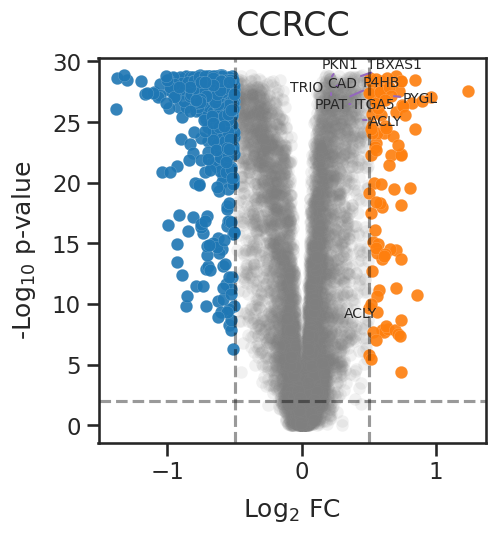

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Get the base scatter plot
sns.scatterplot(
    data=aggregated,
    x="FC", 
    y="FDR", 
    alpha=0.1, 
    linewidth=0.1,
    color="#7f7f7f",
    ax=ax,
)
# Add the up-regulated proteins
sns.scatterplot(
    data=up_df,
    x="FC", 
    y="FDR", 
    alpha=0.9, 
    linewidth=0.1,
    color="#ff7f0e",
    ax=ax
)
# Add the down-regulated proteins
sns.scatterplot(
    data=down_df,
    x="FC", 
    y="FDR", 
    alpha=0.9, 
    linewidth=0.1,
    color="#1f77b4",
    ax=ax
)
labels = []
for idx, row in aggregated.iterrows():
    if row["HGNC"] in savage_mapper[curr_cohort]:
        x_coord = row["FC"]
        y_coord = row["FDR"]
        labels.append(ax.text(x_coord, y_coord, s=row["HGNC"], fontsize=10))

adjust_text(labels, arrowprops=dict(arrowstyle='-', lw=1.5, color="#9467bd"))

ax.set_title(curr_cohort, pad=16, size=24)
ax.set_xlabel("Log$_{2}$ FC", labelpad=10)
ax.set_ylabel("-Log$_{10}$ p-value", labelpad=10)
#ax.set_ylabel("")

ax.axvline(fc_thresh ,color="black", linestyle="--", alpha=0.4)
ax.axvline(-fc_thresh ,color="black", linestyle="--", alpha=0.4)
ax.axhline(2, color="black", linestyle="--", alpha=0.4)

#ax.set_xlim(-0.25, 0.25)

#plt.show()
#plt.savefig("../figures/CCRCC-volcano-plot-v4.pdf", bbox_inches="tight")